In [ ]:
# Created on Fri May 20 2022
# Last modified on 19 July 2022

# @author: Ms. Yap Si Qi
# @course: Computer Science (Intelligent System)
# @school: Asia Pacific University
# @tpnumber: TP051058
# @program: text_summarization
# @description: train and test the review summarization model

In [ ]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install the packages
!pip install rouge_score
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 6.8 MB/s 
     |████████████████████████████████| 596 kB 35.5 MB/s 
     |████████████████████████████████| 6.6 MB 33.5 MB/s 
     |████████████████████████████████| 101 kB 5.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 8.0 MB/s 
     |████████████████████████████████| 140 kB 45.1 MB/s 
     |████████████████████████████████| 212 kB 72.4 MB/s 
     |████████████████████████████████| 1.1 MB 51.4 MB/s 
     |████████████████████████████████| 127 kB 49.8 MB/s 
     |█████████████████████████████

In [ ]:
# import libraries
import nltk
import regex
import pandas as pd 
import numpy as np
from pprint import pprint
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import transformers
from transformers import BertTokenizerFast, TFEncoderDecoderModel, AdamWeightDecay
from sklearn.model_selection import train_test_split
import datasets
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Data Preparation

In [ ]:
# read csv
df_reviews = pd.read_csv('/content/drive/MyDrive/Reviews.csv')
df_reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [ ]:
df_reviews.shape

(568454, 10)

In [ ]:
# drop the duplicated reviews and reviews without summaries
df_reviews.drop_duplicates(subset=['UserId','Text'], inplace=True)
df_reviews.dropna(subset=['Summary'], inplace=True)
df_reviews.reset_index(inplace=True)

In [ ]:
df_reviews.shape

(393603, 11)

Text(0.5, 1.0, 'Histogram of length of tokenized summary')

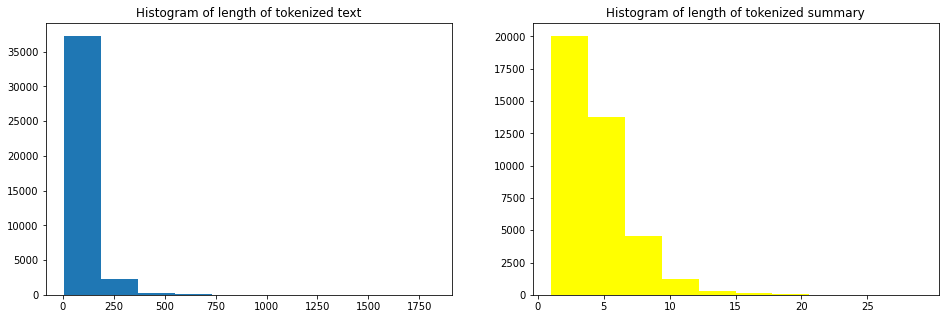

In [ ]:
# shuffle the dataframe
df_reviews_sampled = df_reviews.sample(frac=1, ignore_index=True).copy()

# sampling 40000 pairs of reviews for BERT transfer learning
df_reviews_sampled = df_reviews_sampled.iloc[:40000, :]
df_reviews_sampled['text_len'] = df_reviews_sampled['Text'].apply(lambda x: len(x.split()))
df_reviews_sampled['summary_len'] = df_reviews_sampled['Summary'].apply(lambda x: len(x.split()))

# plot the length of sampled reviews and summary to decide the input length of encoder and decoder sequence
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax[0].hist(df_reviews_sampled['text_len'])
ax[0].set_xticks(np.arange(0, max(df_reviews_sampled['text_len'])+1,250))
ax[0].set_title('Histogram of length of tokenized text')

ax[1].hist(df_reviews_sampled['summary_len'], color='yellow')
ax[1].set_xticks(np.arange(0, max(df_reviews_sampled['summary_len'])+1,5))
ax[1].set_title('Histogram of length of tokenized summary')

In [ ]:
# using extended contractions list
contractions = {"i'm": "i am", "i'm'a": "i am about to", "i'm'o": "i am going to", "i've": "i have", "i'll": "i will", "i'll've": "i will have", "i'd": "i would", "i'd've": "i would have", "whatcha": "what are you", "amn't": "am not", "ain't": "are not", "aren't": "are not", "'cause": "because", "can't": "cannot", "can't've": "cannot have", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "daren't": "dare not", "daresn't": "dare not", "dasn't": "dare not", "didn't": "did not", "didn’t": "did not", "don't": "do not", "don’t": "do not", "doesn't": "does not", "e'er": "ever", "everyone's": "everyone is", "finna": "fixing to", "gimme": "give me", "gon't": "go not", "gonna": "going to", "gotta": "got to", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he've": "he have", "he's": "he is", "he'll": "he will", "he'll've": "he will have", "he'd": "he would", "he'd've": "he would have", "here's": "here is", "how're": "how are", "how'd": "how did", "how'd'y": "how do you", "how's": "how is", "how'll": "how will", "isn't": "is not", "it's": "it is", "'tis": "it is", "'twas": "it was", "it'll": "it will", "it'll've": "it will have", "it'd": "it would", "it'd've": "it would have", "kinda": "kind of", "let's": "let us", "luv": "love", "ma'am": "madam", "may've": "may have", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "ne'er": "never", "o'": "of", "o'clock": "of the clock", "ol'": "old", "oughtn't": "ought not", "oughtn't've": "ought not have", "o'er": "over", "shan't": "shall not", "sha'n't": "shall not", "shalln't": "shall not", "shan't've": "shall not have", "she's": "she is", "she'll": "she will", "she'd": "she would", "she'd've": "she would have", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "somebody's": "somebody is", "someone's": "someone is", "something's": "something is", "sux": "sucks", "that're": "that are", "that's": "that is", "that'll": "that will", "that'd": "that would", "that'd've": "that would have", "em": "them", "there're": "there are", "there's": "there is", "there'll": "there will", "there'd": "there would", "there'd've": "there would have", "these're": "these are", "they're": "they are", "they've": "they have", "they'll": "they will", "they'll've": "they will have", "they'd": "they would", "they'd've": "they would have", "this's": "this is", "this'll": "this will", "this'd": "this would", "those're": "those are", "to've": "to have", "wanna": "want to", "wasn't": "was not", "we're": "we are", "we've": "we have", "we'll": "we will", "we'll've": "we will have", "we'd": "we would", "we'd've": "we would have", "weren't": "were not", "what're": "what are", "what'd": "what did", "what've": "what have", "what's": "what is", "what'll": "what will", "what'll've": "what will have", "when've": "when have", "when's": "when is", "where're": "where are", "where'd": "where did", "where've": "where have", "where's": "where is", "which's": "which is", "who're": "who are", "who've": "who have", "who's": "who is", "who'll": "who will", "who'll've": "who will have", "who'd": "who would", "who'd've": "who would have", "why're": "why are", "why'd": "why did", "why've": "why have", "why's": "why is", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all're": "you all are", "y'all've": "you all have", "y'all'd": "you all would", "y'all'd've": "you all would have", "you're": "you are", "you've": "you have", "you'll've": "you shall have", "you'll": "you will", "you'd": "you would", "you'd've": "you would have", "'cause": "because", "'d": " would", "'ll": " will", "'re": " are", "'em": " them", "doin'": "doing", "goin'": "going", "nothin'": "nothing", "somethin'": "something", "havin'": "having", "lovin'": "loving", "'coz": "because", "thats": "that is", "whats": "what is", "'aight": "alright", "abt": "about", "acct": "account", "altho": "although", "asap": "as soon as possible", "avg": "average", "b4": "before", "bc": "because", "bday": "birthday", "btw": "by the way", "convo": "conversation", "cya": "see ya", "diff": "different", "dunno": "do not know", "g'day": "good day", "gimme": "give me", "gonna": "going to", "gotta": "got to", "howdy": "how do you do", "idk": "I do not know", "ima": "I am going to", "imma": "I am going to", "innit": "is it not", "iunno": "I do not know", "kk": "okay", "lemme": "let me", "msg": "message", "nvm": "nevermind", "ofc": "of course", "ppl": "people", "prolly": "probably", "pymnt": "payment", "r ": "are ", "rlly": "really", "rly": "really", "rn": "right now", "spk": "spoke", "tbh": "to be honest", "tho": "though", "thx": "thanks", "tlked": "talked", "tmmw": "tomorrow", "tmr": "tomorrow", "tmrw": "tomorrow", "u": "you", "ur": "you are", "n": "and", "wanna": "want to", "woulda": "would have" }

In [ ]:
# get the stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords = [word for word in stopwords if word not in ['not', 'no', 'never', 'nothing', 'nor', 'until']]
stopwords.extend(['would', 'could', 'seems', 'like'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# clean the text
def clean_text(text, lowercase=True, remove_stopwords=False):
    if lowercase:
        text = text.lower()
        
    text = ' '.join([contractions[word] if word in contractions else word for word in text.split()])
    
    text = regex.sub(r'!', ' ! ', text)
    text = regex.sub(r'\?', ' ? ', text)
    text = regex.sub(r'[^a-zA-Z0-9!\?]', ' ', text)
    text = regex.sub(r'\s[0-9]+\s', ' ', text)

    if remove_stopwords:
      text = ' '.join([word for word in text.split() if word not in stopwords])
    
    text = regex.sub(r'\s+', ' ', text)
    
    return text.strip()

In [ ]:
# clean the review
df_reviews_sampled['Text'] = df_reviews_sampled['Text'].apply(lambda x: clean_text(x))
df_reviews_sampled

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_len,summary_len
0,497118,497119,B004E4EBMG,A3A7Y3TSPPZU9T,amazongal,0,0,5,1321574400,Calorie Free Goodness,mio mango peach flavor is just delicious calor...,26,3
1,371492,371493,B001HN5Z4K,A383XURHVF8ON6,Mrs. Kilo Delta,5,5,5,1227312000,"Zoey sez: ""YUM!"" ... Mom sez: ""Er, there's cor...",made in the usa no by products no wheat gluten...,385,12
2,460686,460687,B000KLZ5Z4,AFB2SUVMJHEL6,Lintee,0,0,3,1289433600,Over priced,the eucalyptus flavor is no different than a c...,37,2
3,50229,50230,B000YV9QMI,A3CP1WGNTOSKDA,"Tim Naff ""Tim""",14,14,5,1252800000,High Quality,there is a lot of variability in the quality o...,224,2
4,106149,106150,B004I5KOM2,A1CRT2UI0YIOQN,Krista,0,0,5,1351123200,We All Love These,my whole family including two kids ages and lo...,27,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,226147,226148,B0036X748E,AFW15XOVL7PB0,"regbur ""regbur""",0,0,4,1241395200,Great product,i have to say i love evo my yorkie use to poop...,108,2
39996,424480,424481,B005R8FP64,AQOFXCSTJ7HVG,Pammy The Fairy,0,0,5,1347667200,An EXCELLENT Choice!,one wonders how s bucks has a chance with the ...,49,3
39997,361602,361603,B000EM8UBU,A7AY2U96CGU38,Penelopa,2,2,5,1242518400,Perfect lemon herb tea,this is the best lemon herb tea it has a perfe...,22,4
39998,547906,547907,B001E96USC,ASEBX8TBYWQWA,"Steven I. Ramm ""Steve Ramm &#34;Anything Phon...",0,0,5,1265068800,SUPEr easy and delicious! and yoiu don't need ...,i usually cover books dvd and cds on amazon bu...,150,11


# Setup

In [ ]:
# configure the training parameters
class TrainingConfig:
    val_split = 0.2
    pretrained_checkpoint = 'bert-base-uncased'
    encoder_checkpoint = 'bert-base-uncased'
    decoder_checkpoint = 'bert-base-uncased'
    pad_token_id = 0 
    shared_weight = False
    encoder_max_len = 256 
    decoder_max_len = 40 
    nb_epoch = 3 
    learning_rate = 3e-5 
    batch_size = 8 
    
    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

In [ ]:
# load the train and validation dataset
class DataLoader:
    def __init__(self, paragraphs, summaries, **kwargs):
        self.paragraphs = paragraphs 
        self.summaries = summaries 
        self.tokenizer = kwargs.get('tokenizer')
        self.val_split = kwargs.get('val_split')
        self.encoder_max_len = kwargs.get('encoder_max_len')
        self.decoder_max_len = kwargs.get('decoder_max_len')
    
    @property
    def sample_size(self):
        assert len(self.paragraphs)==len(self.summaries)
        return len(self.paragraphs)
    
    def split_train_test(self):
        train_idx, val_idx = train_test_split(
            list(range(self.sample_size)), 
            test_size=self.val_split, 
            random_state=98
        )
        return train_idx, val_idx
    
    def convert_text_to_ids(self, input_paragraphs, input_summaries):
        inputs = self.tokenizer(
            list(input_paragraphs), 
            return_tensors='np', 
            padding='max_length', 
            truncation=True, 
            max_length=self.encoder_max_len
        )
        outputs = self.tokenizer(
            list(input_summaries), 
            return_tensors='np', 
            padding='max_length', 
            truncation=True, 
            max_length=self.decoder_max_len
        )
        return inputs, outputs
    
    def list_to_tensor_dataset(self, input_paragraphs, input_summaries):
        inputs, outputs = self.convert_text_to_ids(
            input_paragraphs, 
            input_summaries
        )
        input_ids = tf.data.Dataset.from_tensor_slices(
            inputs['input_ids']
        )
        attention_masks = tf.data.Dataset.from_tensor_slices(
            inputs['attention_mask']
        )
        output_ids = tf.data.Dataset.from_tensor_slices(
            outputs['input_ids']
        )
        output_attention_masks = tf.data.Dataset.from_tensor_slices(
            outputs['attention_mask']
        )                                                
        tf_dataset = tf.data.Dataset.zip(
            ({
                'input_ids': input_ids, 
                'attention_mask': attention_masks,
                'decoder_input_ids': output_ids, 
                'decoder_attention_mask': output_attention_masks
            }, 
            output_ids)
        )
        return tf_dataset
    
    def __call__(self):
        train_idx, val_idx = self.split_train_test()
        train_paras, val_paras = self.paragraphs[train_idx], self.paragraphs[val_idx]
        train_sums, val_sums = self.summaries[train_idx], self.summaries[val_idx]
        train_dataset = self.list_to_tensor_dataset(train_paras, train_sums)
        val_dataset = self.list_to_tensor_dataset(val_paras, val_sums)
        return train_dataset, val_dataset

In [ ]:
# define loss function 
class Seq2SeqLoss(tf.keras.losses.Loss):
    def __init__(self, pad_token_id, name="seq2seq_loss"):
        super().__init__(name=name)
        self.pad_token_id = pad_token_id

    def call(self, y_true, y_pred):
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )
        output_logits = y_pred[:,:-1,:]
        input_labels = y_true[:,1:] 
        loss = loss_fn(input_labels, output_logits)
        # calculate loss without the padding tokens in label sequence
        mask = tf.cast((input_labels != self.pad_token_id), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [ ]:
# define training and validation step
class Trainer:
    def __init__(self, model, loss_fn, optimizer, metric):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.metric = metric
        # track the mean of loss 
        self.loss_tracker = tf.keras.metrics.Mean(name='mean_loss')
    
    # Training Step
    @tf.function 
    def train_step(self, inputs):
        input_seqs, input_labels = inputs
        with tf.GradientTape() as tape: 
            outputs = self.model(
                input_seqs['input_ids'],
                input_seqs['attention_mask'],
                input_seqs['decoder_input_ids'],
                input_seqs['decoder_attention_mask'],
                training = True
            )
            logits = outputs.logits
            loss = self.loss_fn(input_labels, logits)
        gradients = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.model.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return loss
        
    # Validation Step
    @tf.function  
    def val_step(self, inputs):
        input_seqs, input_labels = inputs
        outputs = self.model(                
                input_seqs['input_ids'],
                input_seqs['attention_mask'],
                input_seqs['decoder_input_ids'],
                input_seqs['decoder_attention_mask'],
                training = False
        )
        logits = outputs.logits
        loss = self.loss_fn(input_labels, logits)
        self.loss_tracker.update_state(loss)
        return loss

In [ ]:
# generate the summary
def batched_generate_summary(model, tokenizer, batched_input):
    input_seqs, input_labels = batched_input
    outputs = model.generate(
        input_ids=input_seqs['input_ids'], 
        attention_mask=input_seqs['attention_mask']
    )
    output_strs = tokenizer.batch_decode(
        outputs, 
        skip_special_tokens=True
    )
    output_gold = tokenizer.batch_decode(
        input_seqs['decoder_input_ids'], 
        skip_special_tokens=True
    )
    input_strs = tokenizer.batch_decode(
        input_seqs['input_ids'], 
        skip_special_tokens=True
    )
    return output_strs, output_gold, input_strs

# Training

In [ ]:
# prepare the training set and validation set
reviews = df_reviews_sampled['Text'].values
summaries = df_reviews_sampled['Summary'].values

training_config = TrainingConfig(nb_epoch=4)
tokenizer = BertTokenizerFast.from_pretrained(training_config.encoder_checkpoint)

dataloader_args = {
    'tokenizer': tokenizer,
    'val_split': training_config.val_split,
    'encoder_max_len': training_config.encoder_max_len,
    'decoder_max_len': training_config.decoder_max_len
}
dataloader = DataLoader(reviews, summaries, **dataloader_args)
train_dataset, val_dataset = dataloader()
train_dataset = (train_dataset
                 .shuffle(int(dataloader.sample_size*(1-training_config.val_split)))
                 .batch(training_config.batch_size))
val_dataset = val_dataset.batch(training_config.batch_size)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# define architecture
bert2bert = TFEncoderDecoderModel.from_encoder_decoder_pretrained(
    training_config.encoder_checkpoint, 
    training_config.decoder_checkpoint,
    tie_encoder_decoder=training_config.shared_weight
)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
All model checkpoint layers were used when initializing TFBertLMHeadModel.

Some layers of TFBertLMHeadModel were not initialized from the model checkpoint at bert

In [ ]:
bert2bert.save_pretrained('bert2bert')
bert2bert = TFEncoderDecoderModel.from_pretrained('bert2bert')

All model checkpoint layers were used when initializing TFEncoderDecoderModel.

All the layers of TFEncoderDecoderModel were initialized from the model checkpoint at bert2bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFEncoderDecoderModel for predictions without further training.


In [ ]:
# configure the special tokens in encoder and decoder
bert2bert.config.decoder_start_token_id = tokenizer.cls_token_id # 101
bert2bert.config.eos_token_id = tokenizer.sep_token_id # 102 
bert2bert.config.pad_token_id = tokenizer.pad_token_id # 0
bert2bert.config.vocab_size = bert2bert.config.encoder.vocab_size 

# configure the parameters of beam search in decoding process
bert2bert.config.max_length = 30
bert2bert.config.min_length = 3
bert2bert.config.no_repeat_ngram_size = 2
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 4

In [ ]:
# training 
rouge = datasets.load_metric('rouge')
tf.keras.backend.clear_session()
trainer = Trainer(model=bert2bert,
                  loss_fn=Seq2SeqLoss(training_config.pad_token_id),
                  optimizer=AdamWeightDecay(
                      learning_rate=training_config.learning_rate, 
                      weight_decay_rate=0.005
                  ),
                  metric=None)

avg_train_loss = defaultdict()
avg_val_loss = defaultdict()

for epoch in range(training_config.nb_epoch):
    print(f'\nEpoch {epoch+1}\n')
    print('Training....')
    for step,batched_input in enumerate(tqdm(train_dataset)):
        loss = trainer.train_step(batched_input)
        till_now_loss = trainer.loss_tracker.result()
        if step%200 == 0:
            print(f'Training loss for one batch at step {step}: {round(till_now_loss,3)}') 
    avg_train_loss[epoch+1] = till_now_loss
    trainer.loss_tracker.reset_states()
    
    print('Validating....')
    for step, batched_input in enumerate(tqdm(val_dataset)):
        val_loss = trainer.val_step(batched_input)
    till_now_val_loss = trainer.loss_tracker.result()    
    print(f'Validation loss: {round(till_now_val_loss,3)}')
    bert2bert.save_pretrained(
        f'bert2bert-Checkpoint-epoch{epoch+1}-loss{round(till_now_val_loss,3)}'
    )
    avg_val_loss[epoch+1] = till_now_val_loss
    trainer.loss_tracker.reset_states()


Epoch 1

Training....


  0%|          | 0/4000 [00:00<?, ?it/s]

Training loss for one batch at step 0: 10.930999755859375
Training loss for one batch at step 200: 6.311999797821045
Training loss for one batch at step 400: 5.767000198364258
Training loss for one batch at step 600: 5.4710001945495605
Training loss for one batch at step 800: 5.258999824523926
Training loss for one batch at step 1000: 5.103000164031982
Training loss for one batch at step 1200: 4.978000164031982
Training loss for one batch at step 1400: 4.869999885559082
Training loss for one batch at step 1600: 4.7729997634887695
Training loss for one batch at step 1800: 4.693999767303467
Training loss for one batch at step 2000: 4.638000011444092
Training loss for one batch at step 2200: 4.591000080108643
Training loss for one batch at step 2400: 4.546000003814697
Training loss for one batch at step 2600: 4.5
Training loss for one batch at step 2800: 4.458000183105469
Training loss for one batch at step 3000: 4.420000076293945
Training loss for one batch at step 3200: 4.38800001144409

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation loss: 3.7100000381469727

Epoch 2

Training....


  0%|          | 0/4000 [00:00<?, ?it/s]

Training loss for one batch at step 0: 3.3380000591278076
Training loss for one batch at step 200: 3.375999927520752
Training loss for one batch at step 400: 3.4210000038146973
Training loss for one batch at step 600: 3.433000087738037
Training loss for one batch at step 800: 3.447000026702881
Training loss for one batch at step 1000: 3.437999963760376
Training loss for one batch at step 1200: 3.428999900817871
Training loss for one batch at step 1400: 3.4260001182556152
Training loss for one batch at step 1600: 3.4210000038146973
Training loss for one batch at step 1800: 3.4230000972747803
Training loss for one batch at step 2000: 3.4170000553131104
Training loss for one batch at step 2200: 3.4200000762939453
Training loss for one batch at step 2400: 3.4189999103546143
Training loss for one batch at step 2600: 3.4149999618530273
Training loss for one batch at step 2800: 3.4140000343322754
Training loss for one batch at step 3000: 3.4089999198913574
Training loss for one batch at step 

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation loss: 3.5329999923706055

Epoch 3

Training....


  0%|          | 0/4000 [00:00<?, ?it/s]

Training loss for one batch at step 0: 3.6070001125335693
Training loss for one batch at step 200: 2.872999906539917
Training loss for one batch at step 400: 2.874000072479248
Training loss for one batch at step 600: 2.884000062942505
Training loss for one batch at step 800: 2.880000114440918
Training loss for one batch at step 1000: 2.8919999599456787
Training loss for one batch at step 1200: 2.8940000534057617
Training loss for one batch at step 1400: 2.9019999504089355
Training loss for one batch at step 1600: 2.9000000953674316
Training loss for one batch at step 1800: 2.9030001163482666
Training loss for one batch at step 2000: 2.9030001163482666
Training loss for one batch at step 2200: 2.9089999198913574
Training loss for one batch at step 2400: 2.9089999198913574
Training loss for one batch at step 2600: 2.9119999408721924
Training loss for one batch at step 2800: 2.9140000343322754
Training loss for one batch at step 3000: 2.9140000343322754
Training loss for one batch at step

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation loss: 3.5220000743865967

Epoch 4

Training....


  0%|          | 0/4000 [00:00<?, ?it/s]

Training loss for one batch at step 0: 2.8340001106262207
Training loss for one batch at step 200: 2.3589999675750732
Training loss for one batch at step 400: 2.381999969482422
Training loss for one batch at step 600: 2.3940000534057617
Training loss for one batch at step 800: 2.4000000953674316
Training loss for one batch at step 1000: 2.4049999713897705
Training loss for one batch at step 1200: 2.4130001068115234
Training loss for one batch at step 1400: 2.4200000762939453
Training loss for one batch at step 1600: 2.4210000038146973
Training loss for one batch at step 1800: 2.428999900817871
Training loss for one batch at step 2000: 2.433000087738037
Training loss for one batch at step 2200: 2.437999963760376
Training loss for one batch at step 2400: 2.443000078201294
Training loss for one batch at step 2600: 2.447000026702881
Training loss for one batch at step 2800: 2.4509999752044678
Training loss for one batch at step 3000: 2.4570000171661377
Training loss for one batch at step 3

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation loss: 3.621000051498413


# Evaluation

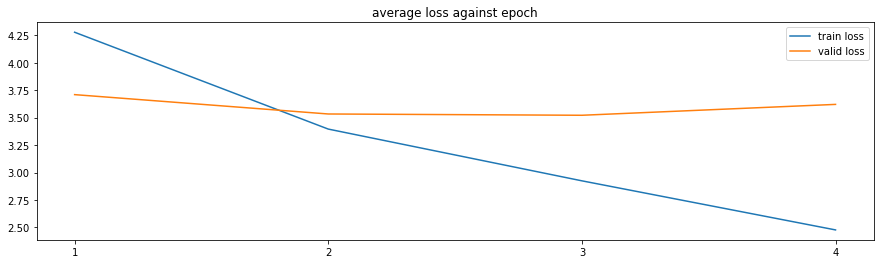

In [ ]:
# plot the training loss and validation loss against epoch
y_train =[value for key, value in avg_train_loss.items()]
y_val =[value for key, value in avg_val_loss.items()]
x = [key for key, value in avg_train_loss.items()]
plt.figure(figsize=(15,4))
plt.plot(x, y_train, label="train loss")
plt.plot(x, y_val, label=f"valid loss")
plt.xticks(x)
plt.title('average loss against epoch')
plt.legend()
plt.show()

In [ ]:
# load the best model checkpoint
trained_bert2bert = TFEncoderDecoderModel.from_pretrained(
    '/content/drive/MyDrive/bert2bert-Checkpoint-epoch3-loss3.5220000743865967'
)

All model checkpoint layers were used when initializing TFEncoderDecoderModel.

All the layers of TFEncoderDecoderModel were initialized from the model checkpoint at /content/drive/MyDrive/bert2bert-Checkpoint-epoch3-loss3.5220000743865967.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFEncoderDecoderModel for predictions without further training.


In [ ]:
# generate the summary of validation set
rouge = datasets.load_metric('rouge')
for step, batched_input in enumerate(tqdm(val_dataset)):
    pred_str, gold_str, input_strs = batched_generate_summary(
        trained_bert2bert, 
        tokenizer, 
        batched_input
    )
    rouge_output = rouge.compute(
        predictions=pred_str,
        references=gold_str,
        rouge_types=["rouge1"]
    )
    print('Rouge report: ')
    print(rouge_output['rouge1'].mid)
    for p_str,g_str,in_str in zip(pred_str, gold_str, input_strs):
        print('='*100)
        print('Review: ' + in_str)
        print('Summary: ' + g_str)
        print('Generated: ' + p_str)
    
    break

  0%|          | 0/1000 [00:00<?, ?it/s]

Rouge report: 
Score(precision=0.22916666666666666, recall=0.14682539682539683, fmeasure=0.1755827505827506)
Review: in a word amazing imagine chocolate without toxic sugar and gas inducing malitol they are high in fiber and great in taste chocoperfection is the way to go if you are on a diet and want to indulge now and then i believe the woman who makes these delicious treats initially came up with these chocolates as a way to lose weight whatever the reason way to go! br br i highly recommend them br br by the way if you find the price a bit too high remember that they are sweetened with erythritol which will command a higher price since that particular sweetener is pricey
Summary: wow! chocolate without the guilt.
Generated: delicious and healthy!
Review: i thought purchasing this item in bulk would save me considerable money vs purchasing this item at the local stop shop the bags are half the size and the savings was negligible br not worth the effort to order wait and unpack the m

In [ ]:
# compute the rouge1 score over 1000 unseen samples
df_reviews_test = df_reviews.copy()
df_reviews_test = df_reviews_test.iloc[40000:41000, :]
test_reviews = df_reviews_test['Text'].values
test_sums = df_reviews_test['Summary'].values

test_dataloader = DataLoader(test_reviews, test_sums, **dataloader_args)
test_dataset = test_dataloader.list_to_tensor_dataset(test_reviews, test_sums)
test_dataset = test_dataset.batch(training_config.batch_size)
pred_strs = []
gold_strs = []

for batched_input in tqdm(test_dataset):
    pred_str, gold_str, _ = batched_generate_summary(
        trained_bert2bert, 
        tokenizer, 
        batched_input
    )
    pred_strs.extend(pred_str)
    gold_strs.extend(gold_str)
    
rouge_output = rouge.compute(
    predictions=pred_strs,
    references=gold_strs,
    rouge_types=["rouge1"]
)
pprint(rouge_output)

  0%|          | 0/125 [00:00<?, ?it/s]

{'rouge1': AggregateScore(low=Score(precision=0.15422259920634923, recall=0.13835040078879673, fmeasure=0.1353479264378033), mid=Score(precision=0.16906011904761908, recall=0.153613433356719, fmeasure=0.14927733816725977), high=Score(precision=0.18521126984126984, recall=0.1695178853108535, fmeasure=0.16427841332973325))}
